# Изменения

* Картинки не втупую кастуются к 768x768, а выполняется rescale 0.25 (Поэтому теперь не все имеют одинаковый размер 768 x 768, и прописан collate_batch!

# CoaT small parallel

In [1]:
CURRENT_FOLD = 3

# imports

In [2]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torch.cuda.amp as amp
is_amp = True

# preparing data

In [3]:
# for fname in tqdm(sorted(glob('./../data/train_images/*.tiff'))):
#     img = cv.imread(fname)
#     bname = os.path.basename(fname).split('.')[0]
#     img = cv.resize(img, None, fx=0.25, fy=0.25, interpolation=cv.INTER_AREA)
#     cv.imwrite('./data/{}.png'.format(bname), img)

In [4]:
# for fname in tqdm(sorted(glob('./../data/train_masks/*.npy'))):
#     mask = np.load(fname)
#     bname = os.path.basename(fname).split('.')[0]
#     mask = cv.resize(mask, None, fx=0.25, fy=0.25, interpolation=cv.INTER_AREA)
#     cv.imwrite('./masks_sc_025/{}.png'.format(bname), mask)

# data

In [5]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

# model testing

In [6]:
from model_coat_daformer import *
from coat import *

In [7]:
encoder = coat_parallel_small
decoder = daformer_conv3x3

model = Net(encoder=encoder, decoder=decoder, n_classes=6)

In [8]:
sample_input = torch.randn(1, 3, 768, 768)

In [9]:
sample_output = model({'image': sample_input, 'organ': [2]})

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [10]:
sample_output.keys()

dict_keys(['aux_parallel_0', 'aux_parallel_1', 'aux_parallel_2', 'aux_parallel_3', 'aux_serial_0', 'aux_serial_1', 'aux_serial_2', 'aux_serial_3', 'logits'])

In [11]:
for key in sample_output.keys():
    print(key, sample_output[key].shape)

aux_parallel_0 torch.Size([1, 6, 192, 192])
aux_parallel_1 torch.Size([1, 6, 96, 96])
aux_parallel_2 torch.Size([1, 6, 48, 48])
aux_parallel_3 torch.Size([1, 6, 24, 24])
aux_serial_0 torch.Size([1, 6, 192, 192])
aux_serial_1 torch.Size([1, 6, 96, 96])
aux_serial_2 torch.Size([1, 6, 48, 48])
aux_serial_3 torch.Size([1, 6, 24, 24])
logits torch.Size([1, 6, 768, 768])


## data 768

In [12]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './images_sc_025/'
TRAIN_MASKS_DIR = './masks_sc_025'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022

In [13]:
train_df = pd.read_csv(TRAIN_CSV)

In [14]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [15]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [16]:
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,4.0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,0.0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,0.0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0.0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,4.0


In [17]:
def make_768_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('images_sc_025', 'masks_sc_025')#.replace('.png', '.npy')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [18]:
train_df_768 = make_768_dataset(train_df)
print(train_df_768.shape)
train_df_768.head()

(351, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./images_sc_025/10044.png,./masks_sc_025/10044.png,prostate,0.4
1,0.0,10274,./images_sc_025/10274.png,./masks_sc_025/10274.png,prostate,0.4
2,0.0,10392,./images_sc_025/10392.png,./masks_sc_025/10392.png,spleen,0.4
3,0.0,10488,./images_sc_025/10488.png,./masks_sc_025/10488.png,lung,0.4
4,4.0,10610,./images_sc_025/10610.png,./masks_sc_025/10610.png,spleen,0.4


In [19]:
train_df_768.iloc[0]['image']

'./images_sc_025/10044.png'

In [20]:
train_df_768.iloc[0]['mask']

'./masks_sc_025/10044.png'

In [21]:
train_df_768.iloc[0]['id']

10044

In [22]:
def pad_to_strided_size(x, shape0, shape1, stride):
    h, w = x.shape[-2:]
    if shape0 % stride > 0:
        new_h = shape0 + stride - shape0 % stride
    else:
        new_h = shape0
    if shape1 % stride > 0:
        new_w = shape1 + stride - shape1 % stride
    else:
        new_w = shape1
        
    lh, uh = int((new_h-h) / 2), int(new_h-h) - int((new_h-h) / 2)
    lw, uw = int((new_w-w) / 2), int(new_w-w) - int((new_w-w) / 2)
    pads = (lw, uw, lh, uh)
    out = F.pad(x, pads, "constant", 0)

    return out, pads

In [23]:
def pad_to_stride(x, stride):
    h, w = x.shape[-2:]

    if h % stride > 0:
        new_h = h + stride - h % stride
    else:
        new_h = h
    if w % stride > 0:
        new_w = w + stride - w % stride
    else:
        new_w = w
    lh, uh = int((new_h-h) / 2), int(new_h-h) - int((new_h-h) / 2)
    lw, uw = int((new_w-w) / 2), int(new_w-w) - int((new_w-w) / 2)
    pads = (lw, uw, lh, uh)

    # zero-padding by default.
    # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
    out = F.pad(x, pads, "constant", 0)

    return out, pads

def unpad_stride(x, pad):
    if pad[2]+pad[3] > 0:
        x = x[:,:,pad[2]:-pad[3],:]
    if pad[0]+pad[1] > 0:
        x = x[:,:,:,pad[0]:-pad[1]]
    return x

In [24]:
# ---------------------------------------------------------------
# WARNING! THIS RESCALE IS INJECTED IN SWIN TRANSFORMER ALREADY!
#   RGB LAYER
# IT'S INPUTS HAVE TO BE IMAGE IN 0..1!
# ---------------------------------------------------------------

In [25]:
mean = np.array([0.0, 0.0, 0.0])
std = np.array([1.0, 1.0, 1.0])

In [26]:
train_transform_1 = A.Compose([
#     A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=(0.02, 0.5), rotate_limit=90, p=0.4),
    A.ElasticTransform(p=0.4, alpha=80, sigma=120 * 0.05, alpha_affine=120 * 0.07),
    A.ElasticTransform(p=0.3, alpha=9000, sigma=80, alpha_affine=120*0.07),
    
    A.GridDistortion(p=0.2),
    A.Blur(blur_limit=7, p=0.1),
    A.GaussNoise(var_limit=100, p=0.4),
    A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, p=0.2),
#     A.ChannelDropout(p=0.05),
    A.RandomGamma(p=0.1),
    A.RandomBrightnessContrast(p=0.1),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/dropout/cutout.py:52: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  FutureWarning,


In [27]:
# train_transform_1 = A.Compose([
# #     A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.HueSaturationValue(p=0.3),
#     A.ShiftScaleRotate(shift_limit=0.5, scale_limit=(-0.2, 0.4), rotate_limit=180, p=0.6),
#     A.ElasticTransform(p=0.4, alpha=80, sigma=120 * 0.05, alpha_affine=120 * 0.07),
#     A.ElasticTransform(p=0.6, alpha=9000, sigma=80, alpha_affine=120*0.07),
    
#     A.GridDistortion(p=0.3),
#     A.Blur(blur_limit=7, p=0.1),
#     A.GaussNoise(var_limit=200, p=0.4),
# #     A.ChannelDropout(p=0.05),
#     A.RandomGamma(p=0.1),
#     A.RandomBrightnessContrast(p=0.2)])

# train_transform_2 = A.Compose([
#     A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], 
#                 max_pixel_value=255, always_apply=True),
#     albumentations.pytorch.ToTensorV2()
# ], p=1)

In [28]:
# from stainaug import Augmentor
# augmentor = Augmentor(factor=0.05)

In [29]:
def bindice(p=0.5):
    return np.random.uniform() < p

In [30]:
def train_transform(image, mask):
    data = dict()
    data['image'] = image
    data['mask'] = mask
    
    data.update(train_transform_1(image=data['image'], mask=data['mask']))
    
#     if bindice(0.5):
#         data['image'] = augmentor.augment_HE(data['image'])
    
#     data.update(train_transform_2(image=data['image'], mask=data['mask']))
      
    return data

In [31]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [32]:
class HubmapDatasetScale025(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        mask = cv.imread(d['mask'], cv.IMREAD_GRAYSCALE)
#         mask = np.load(d['mask'])

        mask = mask / max(1, mask.max())
        
        mask_multiclass = mask * (organ + 1)
        
        data = {
            'image': image,
            'mask': mask_multiclass,
            'organ': organ,
        }
        
        upd_data = self.transform(image=data['image'], mask=data['mask'])

        data.update(upd_data)
        return data

In [33]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [34]:
train_dataset = HubmapDatasetScale025(train_df_768[train_df_768['fold'] != CURRENT_FOLD], train_transform)
val_dataset = HubmapDatasetScale025(train_df_768[train_df_768['fold'] == CURRENT_FOLD], val_transform)

IMAGE
torch.Size([3, 750, 750])
image values:  0.125490203499794 0.960784375667572


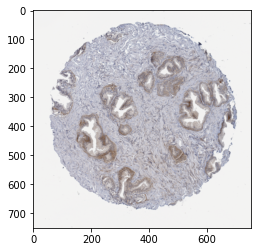

MASK
torch.Size([750, 750])
mask values:  tensor(0., dtype=torch.float64) tensor(2., dtype=torch.float64)


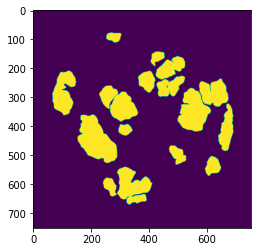

In [35]:
sample = train_dataset[1]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

In [36]:
BATCH_SIZE = 5

In [37]:
def collate_fn_padd(batch):
    '''
    Padds batch
    '''
    max_shape_0 = 0
    max_shape_1 = 0
    for el in batch:
        max_shape_0 = max(max_shape_0, el['image'].shape[1])
        max_shape_1 = max(max_shape_1, el['image'].shape[2])
    
    new_batch = {}
    new_batch['image'] = torch.stack([
        pad_to_strided_size(el['image'], max_shape_0, max_shape_1, 32)[0] 
        for el in batch
    ])
    new_batch['mask']  = torch.stack([
        pad_to_strided_size(el['mask'], max_shape_0, max_shape_1, 32)[0]
        for el in batch
    ])
    new_batch['organ'] = [el['organ'] for el in batch]
    
        
#     ## get sequence lengths
#     lengths = torch.tensor([ t.shape[0] for t in batch ]).to(device)
#     ## padd
#     batch = [ torch.Tensor(t).to(device) for t in batch ]
#     batch = torch.nn.utils.rnn.pad_sequence(batch)
#     ## compute mask
#     mask = (batch != 0).to(device)
    return new_batch

In [38]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          worker_init_fn=worker_init_fn,
                          num_workers=12, collate_fn=collate_fn_padd
                         )
loader_val = DataLoader(val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        worker_init_fn=worker_init_fn,
                        num_workers=0
                       )

IMAGE
torch.Size([3, 717, 717])
image values:  0.062745101749897 1.0


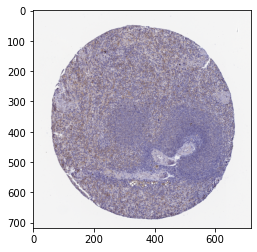

MASK
torch.Size([717, 717])
mask values:  tensor(0., dtype=torch.float64) tensor(4., dtype=torch.float64)


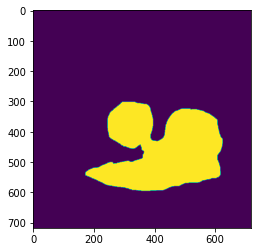

In [39]:
sample = val_dataset[2]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

In [40]:
# for batch in loader_train:
#     print(batch)
#     break

# model

In [41]:
!nvidia-smi

Thu Sep  1 00:58:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   46C    P0    40W / 300W |     57MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   47C    P0    55W / 300W |   1905MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [42]:
device = 'cuda:3'
DEVICE = device

In [43]:
encoder = coat_parallel_small
decoder = daformer_conv3x3

model = Net(encoder=encoder, decoder=decoder, n_classes=6).to(device)

In [44]:
# model.encoder.load_state_dict(torch.load('./../coat-first-try/coat_small_7479cf9b.pth')['model'], strict=False)

In [45]:
# model.load_state_dict(torch.load('./checkpoint_fold_3/INIT_coat-small_ep_080_dice_0.751581.pt'))

In [46]:
model.encoder.load_state_dict(torch.load('./../coat-first-try/coat_small_7479cf9b.pth')['model'], strict=False)

_IncompatibleKeys(missing_keys=['org_tokens1', 'org_tokens2', 'org_tokens3', 'org_tokens4'], unexpected_keys=['norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias', 'norm4.weight', 'norm4.bias', 'aggregate.weight', 'aggregate.bias', 'head.weight', 'head.bias'])

# lr schedule

In [47]:
def lr_function(step):
    start_lr = 1e-5; min_lr = 1e-5; max_lr = 5e-4    #A
    rampup_epochs = 500; sustain_epochs = 15000; exp_decay = .99997    #B
 
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs,
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:    #C
            lr = ((max_lr - start_lr) / rampup_epochs
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:    #D
            lr = max_lr
        else:    #E
#             lr = max((max_lr - min_lr) *
#                       exp_decay**(epoch - rampup_epochs -
#                                     sustain_epochs)* (0.8+0.00*np.sin(epoch / 100)), 0) + min_lr
            lr = 0.00025
        return lr
 
    return lr(step, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay) / max_lr

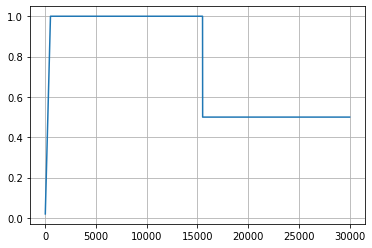

In [48]:
xxx = []
for i in range(30000):
    xxx.append(lr_function(i))
    
plt.plot(xxx)
plt.grid()
plt.show()

# Criterions

In [49]:
import segmentation_models_pytorch as smp

In [50]:
# def criterion_aux_loss(logit, mask):
#     mask = F.interpolate(mask,size=logit.shape[-2:], mode='nearest')
#     print(logit.shape, mask.shape)
#     loss = F.cross_entropy(logit, mask)
#     return loss

In [51]:
ce_loss = nn.CrossEntropyLoss(label_smoothing=0.05).to(device)

In [52]:
criterion_aux_loss = ce_loss

In [53]:
# for iteration, batch in enumerate(loader_train):
#     batch['image'] = batch['image'].half().to(device)
#     batch['mask' ] = batch['mask' ].to(device, dtype=torch.long)
#     break

In [54]:
# torch.tensor([[1, 0, 0, 0, 0, 0]])

In [55]:
# torch.eye(6)[torch.tensor([1, 0, 3])]

In [56]:
kl_loss = nn.KLDivLoss(reduction="mean")

In [57]:
def criterion_aux_scaled(preds, masks, organs):
    B = preds.shape[0]
    pred_shape = tuple(np.array(preds.shape[-2:]))
    masks_np = masks.detach().cpu().numpy().astype(np.float32).transpose((1, 2, 0)) # H W B
#     print(masks_np.shape)
    
#     print(masks_np.shape, masks_np.max())
    masks_np = masks_np / (masks_np.max() + 1e-8)
#     plt.figure(figsize=(9, 9))
#     plt.imshow(masks_np[:, :, 0])
#     plt.show()
#     print(masks_np.max())
    
#     print(pred_shape)
    
    masks_np = cv.resize(masks_np, dsize=pred_shape, interpolation=cv.INTER_AREA)
    
    if len(masks_np.shape) < 3:
        masks_np = masks_np[:, :, None]
#     print(masks_np.shape)
    masks_rescaled = torch.tensor(masks_np).permute((2, 0, 1)).unsqueeze(1)
    
    scales = torch.eye(6)[np.array(organs) + 1].unsqueeze(2).unsqueeze(3)
    scales_back = torch.eye(6)[[0] * B].unsqueeze(2).unsqueeze(3)
    
#     print('!!')
#     print(scales.shape)
#     print(scales_back.shape)
#     print(masks_rescaled.shape)
    
#     new_masks = torch.zeros(B, 6, *pred_shape, dtype=torch.float16)
    
    masks_out = (masks_rescaled * scales + (1 - masks_rescaled) * scales_back).to(device)
    
    input_aux = F.log_softmax(preds, dim=1).to(device)
    loss = kl_loss(input_aux, masks_out)
    
    return loss

In [58]:
# criterion_aux_scaled(torch.randn(5, 6, 48, 48), batch['mask'], [1, 1, 1, 1, 4])

In [59]:
criterion_tversky_punish_fn = smp.losses.TverskyLoss(
    mode='multiclass', classes=None, log_loss=False, 
    from_logits=True, smooth=1e-6, ignore_index=None, 
    eps=1e-07, alpha=0.3, beta=0.7, gamma=3/4
)

criterion_tversky_punish_fp = smp.losses.TverskyLoss(
    mode='multiclass', classes=None, log_loss=False, 
    from_logits=True, smooth=1e-6, ignore_index=None, 
    eps=1e-07, alpha=0.7, beta=0.3, gamma=3/4
)

In [60]:
criterion_dice = smp.losses.TverskyLoss(
    mode='multiclass', classes=None, log_loss=False, 
    from_logits=True, smooth=0.01, ignore_index=None, 
    eps=1e-07, alpha=0.5, beta=0.5, gamma=1
)

In [61]:
def criterion_image_1(predicts, masks):
    return 0.3 * ce_loss(predicts, masks) + 0.7 * criterion_tversky_punish_fn(predicts, masks)

In [62]:
def criterion_image_2(predicts, masks):
    return 0.3 * ce_loss(predicts, masks) + 0.7 * criterion_tversky_punish_fp(predicts, masks)

In [63]:
def criterion_image_3(predicts, masks):
    return 0.1 * ce_loss(predicts, masks) + 0.9 * criterion_dice(predicts, masks)

In [64]:
def criterion_schedule(epoch):
#     if epoch < 40:
    criterion_image = criterion_image_3
    criterion_aux = criterion_aux_scaled
#     elif 40 <= epoch <= 70:
#         criterion_image = criterion_image_1
#         criterion_aux = criterion_aux_loss
#     elif 70 <= epoch <= 80:
#         criterion_image = criterion_image_2
#         criterion_aux = criterion_aux_loss
#     else:
#         criterion_image = criterion_image_3
#         criterion_aux = criterion_aux_loss
        
    return criterion_image, criterion_aux

# validation code

In [65]:
import monai
from monai.utils.enums import BlendMode, PytorchPadMode
from monai.inferers import sliding_window_inference

In [66]:
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union < 1: 
        return 1
    intersection = np.sum(y_true_f * y_pred_f)
#     print('UNION', union)
    return 2. * intersection / union

In [67]:
class Predictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, data):
        out = self.model(data)
        prob = F.softmax(out['logits'], dim=1)
        return prob

In [68]:
def infer_id(predictor, id: str, organ: str, pixel_size=0.4):
    THRESHOLD = 0.5
    
    image = cv.imread('./../data/train_images/{}.tiff'.format(id))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    gt_mask  = np.load('./../data/train_masks/{}.npy'.format(id))
    
    scale_factor = 0.25 * (pixel_size / 0.4)
    image = cv.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)
    
#     image_rot = image.copy()
    masks = []
    for _ in range(1):
#         image_rot = cv.rotate(image, cv.ROTATE_90_CLOCKWISE)
        
        image_tensor = val_transform(image=image)['image']

        image_tensor = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            image_tensor, pads = pad_to_stride(image_tensor, 32)
            infer_result = predictor({'image': image_tensor, 'organ': [ORGAN2ID[organ]]})
#             infer_result = sliding_window_inference(
#                 image_tensor, roi_size=(768, 768), sw_batch_size=2, predictor=predictor, 
#                 overlap=0.25, mode=BlendMode.CONSTANT, sigma_scale=0.125, 
#                 padding_mode=PytorchPadMode.CONSTANT, cval=0.0,       
#             )
            infer_result = unpad_stride(infer_result, pads)
                
        organ_id = ORGAN2ID[organ] + 1
        pr_mask = infer_result.detach().cpu().numpy()[0, organ_id]
        masks.append(pr_mask)
        
    pr_mask = (np.array(masks).mean(axis=0) > THRESHOLD).astype(np.uint8)
#     print(gt_mask.shape, gt_mask.dtype, pr_mask.dtype)
    pr_mask = cv.resize(pr_mask, gt_mask.shape, cv.INTER_NEAREST)
    
    return pr_mask, gt_mask

In [69]:
def validate(val_df, model):
    predictor = Predictor(model)
    
    dices = []
    
    by_organ_dice = {key:[] for key in ORGAN2ID.keys()}
    for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
        id = row['id']
        organ = row['organ']
        pixel_size = row['pixel_size']
        pred_mask, gt_mask = infer_id(predictor, id, organ=organ, pixel_size=pixel_size)
        dice = dice_coef2(gt_mask, pred_mask)
        dices.append(dice)
        by_organ_dice[organ].append(dice)
    new_record = dict()
    new_record['dices'] = dices
    new_record['by_organ'] = by_organ_dice
    return new_record

# training

In [70]:
val_df_id = train_df[train_df['fold'] == CURRENT_FOLD]

In [71]:
learning_rate = 4e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-3)

In [72]:
scaler = amp.GradScaler(enabled = is_amp)

In [73]:
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_function)

In [74]:
# swa_scheduler = SWALR(optimizer, anneal_strategy="linear", anneal_epochs=5, swa_lr=0.00001)

In [75]:
train_loss = []
accuracy = [] 
lr_hist = []

In [76]:
Path('./checkpoint_fold_{}'.format(CURRENT_FOLD)).mkdir(parents=True, exist_ok=True)

In [77]:
logfile = open('./checkpoint_fold_{}'.format(CURRENT_FOLD) + '/log.train.txt', mode='a')
logfile.write('\n--- [START %s] %s\n\n' % ('coat-small-parallel', '-' * 64))

99

In [78]:
def log(string):
    print(string)
    logfile.write(string + '\n')

In [79]:
# SWA_START = 12

In [80]:
N_EPOCHS = 300
global_it = 0
VIRTUAL_BATCH_SIZE = 2

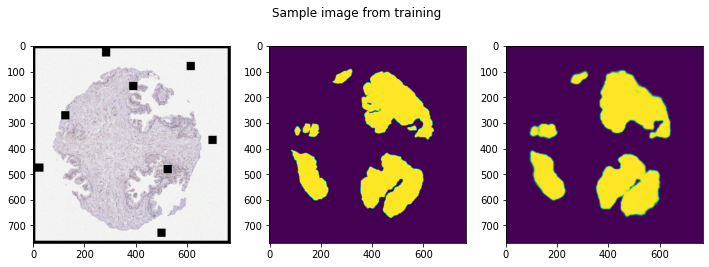

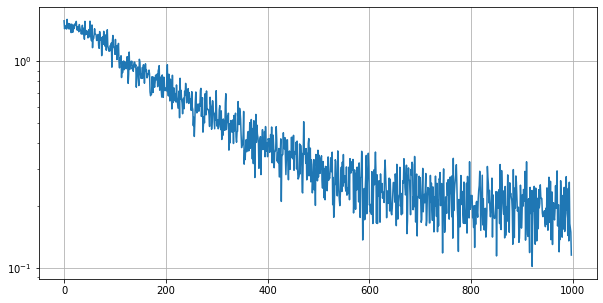

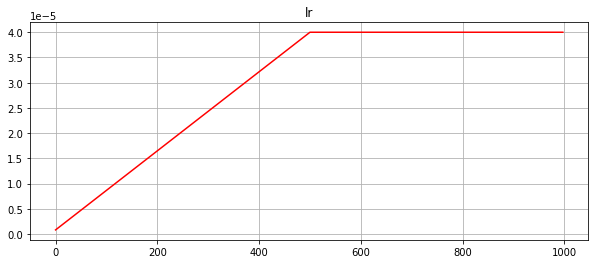

==> Epoch 35 (004/057) | loss: 0.31448


In [ ]:
for epoch in range(0, N_EPOCHS):
    criterion_image, criterion_aux = criterion_schedule(epoch)
    
    model.train()
    
    batch_train_loss = []
    
    for iteration, batch in enumerate(loader_train):
        global_it += 1
        
        batch['image'] = batch['image'].half().to(device)
        batch['mask' ] = batch['mask' ].to(device, dtype=torch.long)
#         batch['organ'] = batch['organ'].cuda()

        with amp.autocast(enabled = is_amp):
            output = model(batch)

            loss_logit      = criterion_image(output['logits'],   batch['mask'])
#             loss_aux0  = criterion_aux  (output['aux0_logits'],  batch['mask']).mean()
            loss_s_aux1  = criterion_aux  (output['aux_serial_1'],  batch['mask'], batch['organ']).mean()
            loss_s_aux2  = criterion_aux  (output['aux_serial_2'],  batch['mask'], batch['organ']).mean()
            loss_s_aux3  = criterion_aux  (output['aux_serial_3'],  batch['mask'], batch['organ']).mean()
        
            loss_p_aux1  = criterion_aux  (output['aux_parallel_1'],  batch['mask'], batch['organ']).mean()
            loss_p_aux2  = criterion_aux  (output['aux_parallel_2'],  batch['mask'], batch['organ']).mean()
            loss_p_aux3  = criterion_aux  (output['aux_parallel_3'],  batch['mask'], batch['organ']).mean()
    
        
#             loss_s_aux3  = criterion_aux  (output['aux_serial_2'],  batch['mask']).mean()
        
        optimizer.zero_grad()
#         loss = loss0 + 0.4 * loss_aux0 + 0.1 * loss_aux1 + 0.005 * loss_aux2
#         loss = loss_logit + \
#             0.05 * loss_s_aux2 + 0.05 * loss_s_aux3 + \
#             0.05 * loss_p_aux2 #+ 0.05 * loss_p_aux3
        loss = loss_logit + \
            0.4 * loss_s_aux1 + 0.4 * loss_s_aux2 + 0.4 * loss_s_aux3 + \
            0.4 * loss_p_aux1 + 0.4 * loss_p_aux2 + 0.4 * loss_p_aux3
            
#         loss = loss_logit + 0.2 * loss_s_aux2
        
        
        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()

        
        # ---
                 
        batch_train_loss.append(loss.item())          
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            train_loss.append(np.mean(batch_train_loss))
            batch_train_loss = []
            lr_hist.append(optimizer.param_groups[0]['lr'])
            scheduler_warmup.step()
                    
        if global_it % (VIRTUAL_BATCH_SIZE * 5) == 0:
            log('==> Epoch {} ({:03d}/{:03d}) | loss: {:.5f}'.format(epoch, iteration, len(loader_train), loss.item()))


        if iteration % (VIRTUAL_BATCH_SIZE * 40) == 0:
            clear_output()
            
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
            fig.suptitle('Sample image from training')
            ax1.imshow(np.clip(batch['image'][0].detach().permute((1, 2, 0)).cpu().numpy() * std + mean, 0, 1.0))
            ax2.imshow(batch['mask'].detach().cpu().numpy()[0])
            pred_mask = torch.softmax(output['logits'].detach(), dim=1)[0, batch['organ'][0] + 1]
            ax3.imshow(pred_mask.cpu().numpy().astype(np.float32), vmin=0.0, vmax=1.0)
            plt.show()

            plt.figure(figsize=(10, 5))
            plt.yscale('log')
            plt.plot(train_loss)
            plt.grid()
            plt.show()
              
            plt.figure(figsize=(10, 4))
            plt.plot(lr_hist, color='red')
            plt.title('lr')
            plt.grid()
            plt.show()
        
    # val -------------------------------
    if epoch % 2 == 0:
        log('Eval')
        model.eval()

        with torch.no_grad():
            val_res = validate(val_df_id, model)
            val_dice = np.mean(val_res['dices'])
            log('DICE: {}'.format(val_dice))
            for key, value in val_res['by_organ'].items():
                log('{:20}: {:6.5f}'.format(key, np.mean(value)))

            torch.save(model.state_dict(), os.path.join(
                './checkpoint_fold_{}'.format(CURRENT_FOLD), 
                'coat-small_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
            )) 
#             if epoch > SWA_START:
#                 torch.save(swa_model.state_dict(), os.path.join(
#                     './checkpoint_fold_{}'.format(CURRENT_FOLD), 
#                     'mit-b2_swa_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
#                 )) 
            logfile.flush()
    

# SWA for CoaT is very special due to shared weights

###  to be done